In [2]:
import numpy as np
from numpy.linalg import inv, det, multi_dot
import random
import math
from sklearn.datasets.samples_generator import make_blobs
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

https://vincentarelbundock.github.io/Rdatasets/doc/car/Davis.html

In [3]:
df = pd.read_csv("Davis.csv")
df["isMale"]= (df["sex"] == "M").astype(int)

In [4]:
y = df.as_matrix(columns=["isMale"]).reshape(200)
X = df.as_matrix(columns=["weight", "height"])

In [5]:
mu_weight, mu_height= np.mean(X, axis =0)
sd_weight, sd_height = np.std(X, axis = 0)
X_norm = np.stack([(X[:,0]-mu_weight)/sd_weight, (X[:,1]-mu_height)/sd_height], axis= -1)

In [6]:
X = X_norm

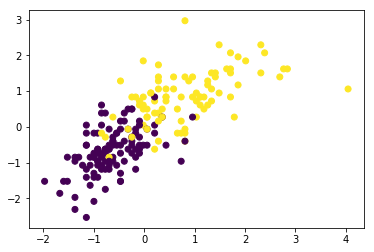

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X_norm[:,0],X_norm[:,1], c= y)

In [8]:
# dim of data
N, D = X.shape
#Sig = np.cov(X, rowvar=False)
#Sig = np.matrix([[0.5,0.2], [0.2, 0.5]])
Sig = np.identity(D)*0.75
mu_0 = np.array([0,0]).reshape(D,1)
Lambda_0 = np.identity(D)*0.75
#Lambda_0 = np.matrix([[0.5,0.2], [0.2, 0.5]])*0.75
Sig_inv = inv(Sig)
Lam_0_inv = inv(Lambda_0)


In [9]:
def dMVN(x, mu, sig):
    d = x.shape[0]
    if d != mu.shape[0] or d != sig.shape[0]:
        print("Unmatched dimension")
        return None
    return (2*math.pi)**(-d/2) * (det(sig))**(-0.5) * \
            math.exp(-0.5* multi_dot([np.transpose(np.subtract(x,mu)),inv(sig),np.subtract(x,mu)])[0][0])

In [ ]:
zt = list(range(N))
Z = np.arange(N).reshape(N,1)
length = []
for run in range(2000):
    #zt_new = list(range(N))
    alpha = np.random.gamma(1,1,1)
    for i in np.random.permutation(N):
        ext_cluster = zt[0:i]+zt[i+1:N]
        cluster_cnt = Counter(ext_cluster)
        p = {}
        # exisiting
        for c in cluster_cnt:
            n_c = cluster_cnt.get(c)
            A = (n_c+1)*Sig_inv+Lam_0_inv
            A_inv = inv(A)
            c_idx = np.where(np.asarray(zt) == c)[0]
            b = np.add(np.matmul(Sig_inv, np.sum([X[j] for j in c_idx], axis = 0)).reshape(D,1), 
                       np.matmul(Lam_0_inv,mu_0))
            sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
            mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
            
            f = dMVN(X[i].reshape(D,1), mu_i_star, sig_i_star)
            p[c] = n_c*f
        # new
        c = list(set(range(N))-set(ext_cluster))[0]
        A = Sig_inv+Lam_0_inv
        A_inv = inv(A)
        b = np.matmul(Lam_0_inv,mu_0)
        sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
        mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
        f = dMVN(X[i].reshape(D,1), mu_i_star, sig_i_star)
        p[c] = alpha * f
        clusters = list(p.keys())
        zt[i] = random.choices(clusters, weights=[p.get(cl) for cl in clusters], k=1)[0]
    length.append(len(set(zt)))
    Z = np.concatenate((Z,np.asarray(zt).reshape(N,1)),axis =1)
    #zt = zt_new
    if run % 100 == 0:
        print("Done {} runs".format(run))
print("Done")

In [10]:
cluster_idx = {(0,0):list(range(N))}
cluster_assigment = dict(zip(list(range(N)), [(0,0)]*N))
length = []
for run in range(2000):
    alpha = np.random.gamma(1,1,1)[0]
    for i in np.random.permutation(N):
        zt =  [cluster_assigment[i] for i in range(N)]
        ext_cluster = zt[0:i]+zt[i+1:N]
        Counter(ext_cluster)
        cluster_cnt = Counter(ext_cluster)
        prob = {}
        # delete cluster assignment for i
        old_c = cluster_assigment[i]
        if len(cluster_idx[old_c]) == 1:
            del cluster_idx[old_c]
        # exisiting
        for c in cluster_cnt:
            n_c = cluster_cnt.get(c)
            A = (n_c+1)*Sig_inv+Lam_0_inv
            A_inv = inv(A)
            c_idx = cluster_idx.get(c)
            if i in c_idx:
                c_idx.remove(i)
                if c_idx:
                    cluster_idx[c] = c_idx
                else:
                    del cluster_idx[c]
            b = np.add(np.matmul(Sig_inv, np.sum([X[j] for j in c_idx], axis = 0)).reshape(D,1), 
                       np.matmul(Lam_0_inv,mu_0))
            sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
            mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])

            f = dMVN(X[i].reshape(D,1), mu_i_star, sig_i_star)
            prob[c] = n_c*f
        # new
        A = Sig_inv+Lam_0_inv
        A_inv = inv(A)
        b = np.matmul(Lam_0_inv,mu_0)
        sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
        mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
        f = dMVN(X[i].reshape(D,1), mu_i_star, sig_i_star)
        prob["new"] = alpha * f
        clusters = list(prob.keys())
        cluster_sample = random.choices(clusters, weights=[prob.get(cl) for cl in clusters], k=1)[0]
        if cluster_sample != "new":
            cluster_assigment[i] = cluster_sample
            cluster_idx[cluster_sample] = cluster_idx.get(cluster_sample)+[i]
            sigma_new = inv(np.add((cluster_cnt.get(cluster_sample)+1)*Sig_inv,Lam_0_inv))
            mu_new = np.matmul(sigma_new, 
                               np.add(np.matmul(Sig_inv, 
                                                np.sum([X[j] for j in cluster_idx[cluster_sample]], axis = 0).reshape(D,1)), 
                                                np.matmul(Lam_0_inv,mu_0)))

            class_param = np.random.multivariate_normal(np.squeeze(np.asarray(mu_new)),sigma_new)

            for idx in cluster_idx.get(cluster_sample):
                cluster_assigment[idx] = tuple(class_param)

            cluster_idx[tuple(class_param)] = cluster_idx[cluster_sample]
            del cluster_idx[cluster_sample]
        else:
            sigma_new = inv(np.add(Sig_inv,Lam_0_inv))
            mu_new = np.matmul(sigma_new, 
                               np.add(np.matmul(Sig_inv, X[i].reshape(D,1)), 
                                      np.matmul(Lam_0_inv,mu_0)))

            class_param = np.random.multivariate_normal(np.squeeze(np.asarray(mu_new)),sigma_new)
            cluster_idx[tuple(class_param)] = [i]
            cluster_assigment[i] = tuple(class_param)
        length.append(len(cluster_idx))
    if run % 100 == 0:
        print("Done {} runs".format(run))
print("Done")

Done 0 runs
Done 100 runs
Done 200 runs
Done 300 runs
Done 400 runs
Done 500 runs
Done 600 runs
Done 700 runs
Done 800 runs
Done 900 runs
Done 1000 runs
Done 1100 runs
Done 1200 runs
Done 1300 runs
Done 1400 runs
Done 1500 runs
Done 1600 runs
Done 1700 runs
Done 1800 runs
Done 1900 runs
Done


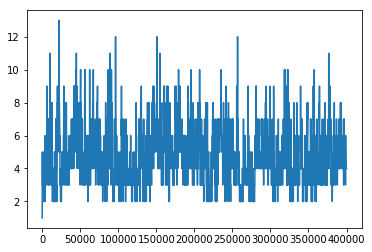

In [11]:
plt.plot(length)
plt.show()
    

In [ ]:
len(cluster_idx)

In [ ]:
zt = [(0,0)]*N
Z = np.arange(N).reshape(N,1)
length = []
for run in range(2000):
    #zt_new = list(range(N))
    alpha = np.random.gamma(1,1,1)
    for i in np.random.permutation(N):
        ext_cluster = zt[0:i]+zt[i+1:N]
        cluster_cnt = Counter(ext_cluster)
        p = {}
        # exisiting
        for c in cluster_cnt:
            n_c = cluster_cnt.get(c)
            A = (n_c+1)*Sig_inv+Lam_0_inv
            A_inv = inv(A)
            c_idx = np.where(np.asarray(zt) == c)[0]
            b = np.add(np.matmul(Sig_inv, np.sum([X[j] for j in c_idx], axis = 0)).reshape(D,1), 
                       np.matmul(Lam_0_inv,mu_0))
            sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
            mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
            
            f = dMVN(X[i].reshape(D,1), mu_i_star, sig_i_star)
            p[c] = n_c*f
        # new
        c = list(set(range(N))-set(ext_cluster))[0]
        A = Sig_inv+Lam_0_inv
        A_inv = inv(A)
        b = np.matmul(Lam_0_inv,mu_0)
        sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
        mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
        f = dMVN(X[i].reshape(D,1), mu_i_star, sig_i_star)
        p[c] = alpha * f
        clusters = list(p.keys())
        zt[i] = random.choices(clusters, weights=[p.get(cl) for cl in clusters], k=1)[0]
    length.append(len(set(zt)))
    Z = np.concatenate((Z,np.asarray(zt).reshape(N,1)),axis =1)
    #zt = zt_new
    if run % 100 == 0:
        print("Done {} runs".format(run))
print("Done")

In [ ]:
from scipy import stats
C = Z[:,1001:]
res = stats.mode(C, axis = 1)[0].reshape(200)
print(set(res))
res

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=res)

In [ ]:
print(np.mean(X[y==1,:], axis = 0))
print(np.mean(X[y==0,:], axis = 0))

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(np.mean(X[kmeans.labels_==1,:], axis = 0))
print(np.mean(X[kmeans.labels_==0,:], axis = 0))